# Week 5 - Logistic Regression and Classification Error Metrics

## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

Alternatively the same data set can be found at https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones/downloads/human-activity-recognition-with-smartphones.zip
The train file can be renamed as Human_Activity_Recognition_Using_Smartphones_Data.csv 

For each record in the dataset it is provided: 

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration. 
- Triaxial Angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 

More information about the features is available on the website above.

In [2]:
from __future__ import print_function
import os
#Data Path has to be set as per the file location in your system
#data_path = ['..', 'data']
data_path = ['data']

## Question 1

Import the data and do the following:

* Examine the data types--there are many columns, so it might be wise to use value counts
* Determine if the floating point values need to be scaled
* Determine the breakdown of each activity
* Encode the activity label as an integer

In [3]:
import pandas as pd
import numpy as np
#The filepath is dependent on the data_path set in the previous cell 
filepath = os.sep.join(data_path + ['Human_Activity_Recognition_Using_Smartphones_Data.csv'])
data = pd.read_csv(filepath, sep=',')

The data columns are all floats except for the activity label.

In [4]:
data.dtypes.value_counts()

float64    561
object       1
dtype: int64

In [5]:
data.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

The data are all scaled from -1 (minimum) to 1.0 (maximum).

In [6]:
data.iloc[:, :-1].min().value_counts()

-1.0    561
dtype: int64

In [7]:
data.iloc[:, :-1].max().value_counts()

1.0    561
dtype: int64

Examine the breakdown of activities--they are relatively balanced.

In [8]:
data.Activity.value_counts()

LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: Activity, dtype: int64

Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.  
Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.

In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)

6877    0
9124    0
663     5
5338    1
7136    5
Name: Activity, dtype: int32

## Question 2

* Calculate the correlations between the dependent variables.
* Create a histogram of the correlation values
* Identify those that are most correlated (either positively or negatively).

In [10]:
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values.stack().to_frame().reset_index().rename(columns={'level_0':'feature1','level_1':'feature2',0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

A histogram of the absolute value correlations.

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

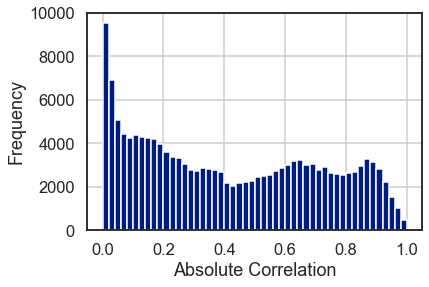

In [12]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

ax = corr_values.abs_correlation.hist(bins=50)

ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [13]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
93902,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
101139,tBodyAccJerkMag-mean(),tBodyAccJerkMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
94257,tBodyAccMag-energy(),tGravityAccMag-energy(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


## Question 3

* Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
* Regardless of methods used to split the data, compare the ratio of classes in both the train and test splits.


In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1,test_size=0.3, random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']

In [15]:
y_train.value_counts(normalize=True)

0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: Activity, dtype: float64

In [16]:
y_test.value_counts(normalize=True)

0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: Activity, dtype: float64

## Question 4

* Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitting a multi-class model so you understand the coefficient output. Store the model.
* Using cross validation to determine the hyperparameters, fit models using L1, and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations. The regularized models, in particular the L1 model, will probably take a while to fit.

In [17]:
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr = LogisticRegression().fit(X_train, y_train)

In [18]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression

#commented so running all cells doesn't take forever

lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear', n_jobs=-1).fit(X_train, y_train)

In [19]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations

#commented so running all cells doesn't take forever

#lr_l1a = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='newton-cg', n_jobs=-1).fit(X_train, y_train)
#lr_l1b = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='lbfgs', n_jobs=-1).fit(X_train, y_train)
#lr_l1c = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='sag', n_jobs=-1).fit(X_train, y_train)
#lr_l1d = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='saga', n_jobs=-1).fit(X_train, y_train)

In [20]:
# L2 regularized logistic regression

#commented so running all cells doesn't take forever

lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', n_jobs=-1).fit(X_train, y_train)

## Question 5

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [21]:
# Combine all the coefficients into a dataframe

coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)

lr                                                          l1  \
            0         1         2         3         4         5         0   
183 -0.116360  0.815596 -1.246381  0.221573  0.329390 -0.003819  0.182171   
115  0.022138 -0.348579  0.393725 -0.041665  0.283902 -0.309520  0.000000   
468 -0.020329  0.060265  0.011999 -0.028243  0.086337 -0.110029 -0.005157   
333 -0.006122  0.048767  0.085167 -0.053063  0.031636 -0.106385  0.036507   
238 -0.044967  0.209781 -0.121556  0.158305 -0.260443  0.058881  0.000000   
442 -0.076989 -0.244780  0.093874 -0.166467 -0.266034  0.660395  0.000000   
130 -0.063697 -0.121667  0.083948  0.386510 -0.147306 -0.137787  0.000000   
480 -0.006595  0.040932  0.080060 -0.105710  0.080569 -0.089255  0.000000   
375  0.007980 -0.353464  0.213312  0.321671 -0.075393 -0.114105  0.000000   
168 -0.103662 -0.079444 -0.005939  0.214786  0.086440 -0.112180 -0.062936   

                                                             l2            \
            1         2         3         4         5         0         1   
183  5.049790 -5.461542  0.348629  0.615384 -1.885663  0.079877  1.939359   
115  0.000000  0.000000 -0.392142  2.868514 -4.644179 -0.008319 -0.152580   
468  0.918729  0.000000  0.073356  0.421215 -0.106578 -0.072287  0.147814   
333  0.430008  0.501653  0.000000  0.179947  0.340883 -0.068786  0.025575   
238  0.183756 -0.092131  0.000000 -2.621316 -0.080835  0.028953  0.313938   
442  0.000000  0.000000 -0.120877 -0.613220  1.198622 -0.074231 -0.366512   
130  0.000000  0.000000  0.863188 -0.660382 -0.649622 -0.058424 -0.376257   
480  0.080671  0.000000  0.000000  0.243127  0.447532 -0.064501  0.010992   
375  0.000000  0.000000  0.853214 -0.006735 -0.954533  0.046634 -0.174752   
168  0.000000  0.000000  0.883763  0.292669 -1.181549 -0.097195 -0.218252   

                                             
            2         3         4         5  
183 -2.291929  0.296673  0.274385 -0.298365  
115  0.238157 -0.047596  0.341571 -0.371233  
468 -0.116728  0.051430  0.124453 -0.134682  
333  0.088555 -0.038644  0.060560 -0.067260  
238 -0.195984  0.229510 -0.470014  0.093596  
442  0.250695 -0.256767 -0.246751  0.693567  
130  0.383546  0.598563 -0.274177 -0.273250  
480  0.097134 -0.044387  0.052709 -0.051947  
375 -0.064972  0.333153  0.027191 -0.167254  
168  0.161406  0.319164  0.127489 -0.292612

Prepare six separate plots for each of the multi-class coefficients.

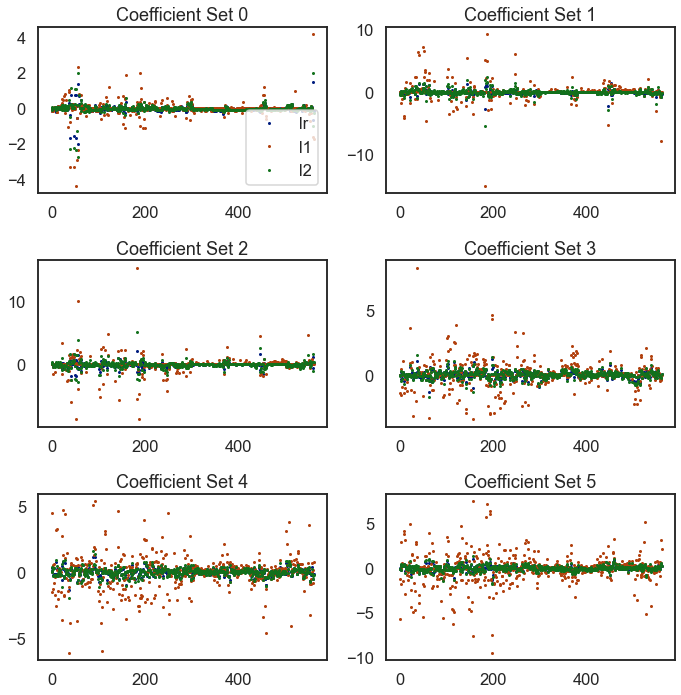

In [22]:

fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data = coefficients.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()


## Question 6

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [23]:
# Predict the class and the probability for each

y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()


,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


In [24]:
y_prob.head()

,lr,l1,l2
0,0.999995,0.999037,0.999997
1,0.999238,0.999768,0.999697
2,0.997367,0.996185,0.998954
3,0.988736,0.999194,0.997830
4,0.995034,0.999922,0.999376


## Question 7

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [25]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics_q7 = pd.concat(metrics, axis=1)


In [26]:
#Run the metrics
metrics_q7

,lr,l1,l2
precision,0.980246,0.984153,0.984134
recall,0.980259,0.984142,0.984142
fscore,0.980248,0.984140,0.984137
accuracy,0.980259,0.984142,0.984142
auc,0.988042,0.990342,0.990380


## Question 8

Display or plot the confusion matrix for each model.

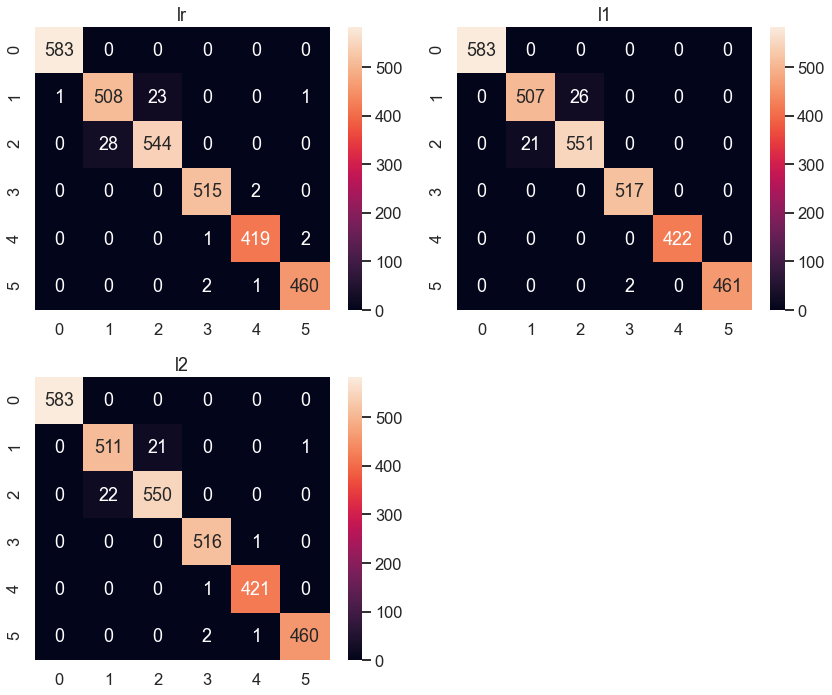

In [27]:

fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()


## Question 9
 Identify highly correlated columns and drop those columns before building models

In [28]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold

#threshold with .7

sel = VarianceThreshold(threshold=(.7 * (1 - .7)))

data2 = pd.concat([X_train,X_test])
data_new = pd.DataFrame(sel.fit_transform(data2))


data_y = pd.concat([y_train,y_test])

from sklearn.model_selection import train_test_split

X_new,X_test_new = train_test_split(data_new)
Y_new,Y_test_new = train_test_split(data_y)

 Repeat Model building with new training data after removing higly correlated columns

In [29]:
# Try standard, L1 and L2 Logistic regression

lr_2 = LogisticRegression().fit(X_new, Y_new)

lr_l1_2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear', n_jobs=-1).fit(X_new, Y_new)
lr_l2_2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear', n_jobs=-1).fit(X_new, Y_new)

In [30]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations

#lr_l1a_2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='newton-cg', n_jobs=-1).fit(X_new, Y_new)
#lr_l1b_2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='lbfgs', n_jobs=-1).fit(X_new, Y_new)
#lr_l1c_2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='sag', n_jobs=-1).fit(X_new, Y_new)
#lr_l1d_2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='saga', n_jobs=-1).fit(X_new, Y_new)

## Question 10

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [31]:
# Combine all the coefficients into a dataframe for comparison
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr_2, lr_l1_2, lr_l2_2]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)


lr                                                     l1            \
           0         1         2         3         4         5    0    1    2   
32 -0.178505 -0.166321  0.061649  0.052838  0.203474  0.026866  0.0  0.0  0.0   
24  0.020734  0.091507 -0.107284  0.040911 -0.145420  0.099553  0.0  0.0  0.0   
6   0.029379 -0.474189  0.317153  0.100939  0.090574 -0.063855  0.0  0.0  0.0   
40 -0.115737 -0.065198  0.302799  0.199982 -0.294087 -0.027759  0.0  0.0  0.0   
12 -0.492732  0.473841 -0.292555  0.096597  0.066511  0.148339  0.0  0.0  0.0   
49 -0.382977  0.163427  0.745124 -0.288283 -0.601342  0.364050  0.0  0.0  0.0   
45 -0.743883  0.657142 -0.213478  0.029154  0.202907  0.068157  0.0  0.0  0.0   
5  -0.140738 -0.044241  0.048644  0.170731 -0.130818  0.096423  0.0  0.0  0.0   
38 -0.208845 -0.170699  0.013881  0.265214 -0.067922  0.168371  0.0  0.0  0.0   
17  0.038276 -0.073871  0.247821  0.304955 -0.117755 -0.399425  0.0  0.0  0.0   

                         l2                                                    
      3    4    5         0         1         2         3         4         5  
32  0.0  0.0  0.0  0.088322  0.094358  0.075303  0.103660  0.118633  0.113213  
24  0.0  0.0  0.0  0.092073  0.093166 -0.014920  0.100366  0.110528  0.115279  
6   0.0  0.0  0.0 -0.076870 -0.107260 -0.008527 -0.076046 -0.111576 -0.094101  
40  0.0  0.0  0.0 -0.019917  0.009418  0.053201 -0.010079 -0.037517 -0.020537  
12  0.0  0.0  0.0 -0.077401 -0.022291 -0.050768 -0.033703 -0.042761 -0.030289  
49  0.0  0.0  0.0  0.004966  0.018185  0.145685  0.010183  0.030309  0.028176  
45  0.0  0.0  0.0 -0.039304  0.000100 -0.072153 -0.037798 -0.051122 -0.033266  
5   0.0  0.0  0.0 -0.106363 -0.120975 -0.094869 -0.107072 -0.148692 -0.123723  
38  0.0  0.0  0.0 -0.055613 -0.022401 -0.034789 -0.027866 -0.034475 -0.035204  
17  0.0  0.0  0.0 -0.036621 -0.046359  0.053767 -0.038527 -0.054715 -0.057210

Prepare six separate plots for each of the multi-class coefficients.

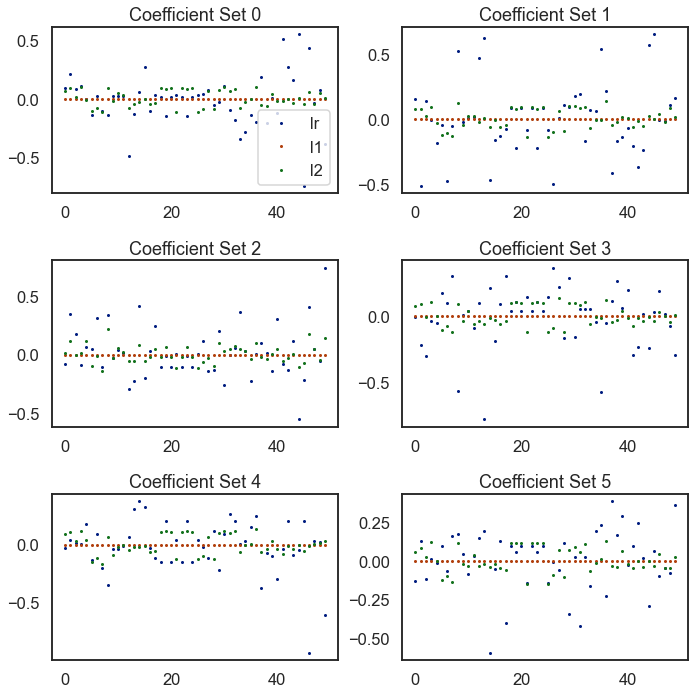

In [32]:
# try the plots

fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data = coefficients.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()

## Question 11

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [33]:
# Predict the class and the probability for each
y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr_2, lr_l1_2, lr_l2_2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test_new), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test_new).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()

,lr,l1,l2
0,0,0,0
1,2,0,2
2,2,0,2
3,2,0,0
4,1,0,1


## Question 12

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [34]:
# Calculate the error metrics as listed above

from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics_new = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(Y_test_new, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(Y_test_new, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(Y_test_new, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(Y_test_new, y_pred[lab])
    
    metrics_new.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics_q12 = pd.concat(metrics_new, axis=1)

In [35]:
#Run the metrics
metrics_q12

,lr,l1,l2
precision,0.152199,0.033742,0.126287
recall,0.173204,0.183689,0.183689
fscore,0.141544,0.057011,0.105822
accuracy,0.173204,0.183689,0.183689
auc,0.497286,0.500000,0.500611


## Question 13

Display or plot the confusion matrix for each model.

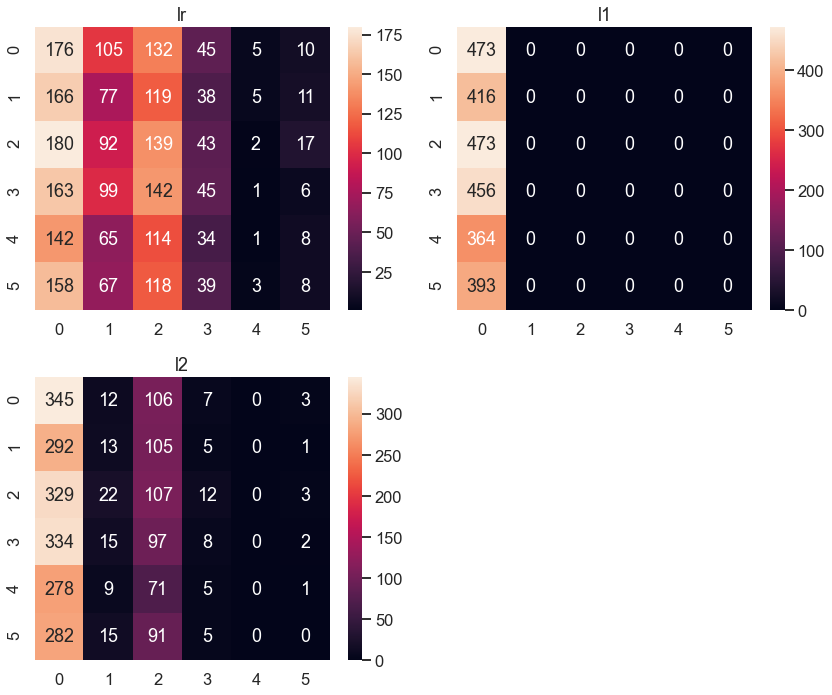

In [36]:
#plot the confusion matrix
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()


In [40]:
# Perform a comparison of the outputs between Question 7 and 12 and give your observation
print(metrics_q7)
print(metrics_q12)



                 lr        l1        l2
precision  0.980246  0.984153  0.984134
recall     0.980259  0.984142  0.984142
fscore     0.980248  0.984140  0.984137
accuracy   0.980259  0.984142  0.984142
auc        0.988042  0.990342  0.990380
                 lr        l1        l2
precision  0.152199  0.033742  0.126287
recall     0.173204  0.183689  0.183689
fscore     0.141544  0.057011  0.105822
accuracy   0.173204  0.183689  0.183689
auc        0.497286  0.500000  0.500611


In [44]:
'The models from question 12 score much lower on every metric than the ones from question 7, however there is a possibility of overfitting because all values are very close to 1'

'The models from question 12 score much lower on every metric than the ones from question 7'

In [42]:
# Perform a comparison of the outputs between Question 8 and 13 and give your observation
'The model used in question 8 produces many more true positives than the model used in question 13, I think this is likely due to the removal of highly correlated columns from the data set'

'The model used in question 8 produces many more true positives than the model used in question 13, I think this is likely due to the removal of highly correlated columns from the data set'